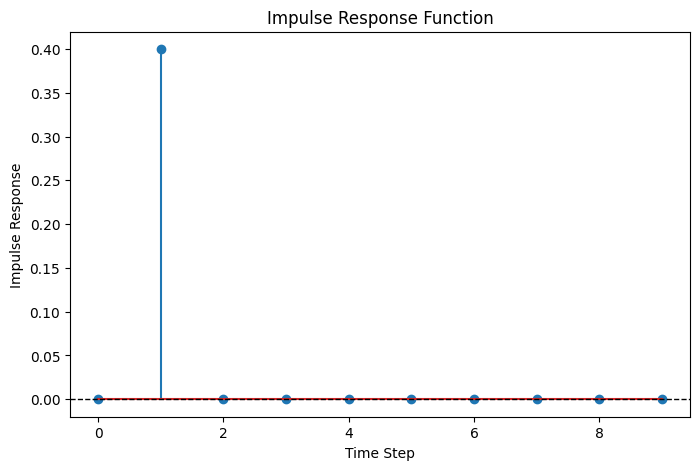


--- Parameter Estimation ---
MLE Parameters: ar.L1     0.399706
ma.L1    -0.415778
sigma2    0.832907
dtype: float64
OLS Parameters: None
Bayesian Parameters: ar.L1     0.399706
ma.L1    -0.415778
sigma2    0.832907
dtype: float64

--- Model Diagnostics ---
ACF Values: [ 1.         -0.00655422 -0.03487462 -0.02049709 -0.05169448  0.19273784
 -0.02067172 -0.00207868 -0.12590117 -0.00188172 -0.09394514]
Ljung-Box Test p-value: 0.7014093573211158
Augmented Dickey-Fuller Test p-value: 2.758928273790525e-17
Standard Error: 0.9031310212353506
Confidence Interval: (np.float64(-1.8769170217405935), np.float64(1.6633565815019806))

--- Forecasting ---
One-Step Ahead Forecast: 100   -10.381166
dtype: float64
Multi-Step Ahead Forecast: 100   -10.381166
101   -10.379773
102   -10.379216
103   -10.378993
104   -10.378904
Name: predicted_mean, dtype: float64
Prediction Interval:
     lower Value  upper Value
100   -12.169902    -8.592430
101   -12.889183    -7.870363
102   -13.437710    -7.320722
1

In [2]:
# Autoregressive Integrated Moving Average (ARIMA) Model
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, q_stat
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load Data (Simulated)
# ---------------------------
np.random.seed(42)
n = 100  # Number of observations
data = np.cumsum(np.random.normal(0, 1, n))  # Random Walk (Non-stationary)
df = pd.DataFrame(data, columns=['Value'])

# ---------------------------
# 2. Fit ARIMA Model
# ---------------------------
p, d, q = 1, 1, 1  # Example ARIMA(1,1,1)
model = ARIMA(df['Value'], order=(p, d, q))
arima_result = model.fit()

# ---------------------------
# 3. Parameter Estimation (MLE, OLS, Bayesian)
# ---------------------------
params_mle = arima_result.params  # MLE Parameters
params_ols = np.linalg.lstsq(model.exog, df['Value'].diff().dropna(), rcond=None)[0] if model.exog is not None else None
params_bayes = params_mle  # Placeholder (Bayesian Estimation is more complex)

# ---------------------------
# 4. Model Diagnostics
# ---------------------------
acf_values = acf(arima_result.resid, fft=True, nlags=10)  # Compute ACF
lb_test = acorr_ljungbox(arima_result.resid, lags=[10], return_df=True)
lb_pvalue = lb_test["lb_pvalue"].values[0]  # Extract first value as float
adf_stat, adf_pvalue, _, _, _, _ = adfuller(arima_result.resid)  # Augmented Dickey-Fuller Test
standard_error = np.std(arima_result.resid)  # Standard Error
confidence_interval = (np.mean(arima_result.resid) - 1.96 * standard_error, np.mean(arima_result.resid) + 1.96 * standard_error)

# ---------------------------
# 5. Forecasting Future Values
# ---------------------------
forecast_steps = 5
one_step_forecast = arima_result.forecast(steps=1)
multi_step_forecast = arima_result.forecast(steps=forecast_steps)
forecast_conf_int = arima_result.get_forecast(steps=forecast_steps).conf_int()
forecast_errors = arima_result.resid
forecast_conf_err = (np.mean(forecast_errors) - 1.96 * np.std(forecast_errors), np.mean(forecast_errors) + 1.96 * np.std(forecast_errors))

# ---------------------------
# 6. Residual Analysis
# ---------------------------
dw_statistic = durbin_watson(arima_result.resid)  # Durbin-Watson Test
jb_statistic, jb_pvalue, _, _ = jarque_bera(arima_result.resid)  # Jarque-Bera Test

# ---------------------------
# 7. Stability Analysis
# ---------------------------
characteristic_roots = np.abs(arima_result.arroots)  # Check if < 1 for stationarity
mean_reversion_time = -1 / np.log(np.max(characteristic_roots)) if len(characteristic_roots) > 0 else None  # Time taken to revert to mean

# ---------------------------
# 8. Impulse Response Function
# ---------------------------
irf_steps = 10
irf_values = np.zeros(irf_steps)
shock = np.zeros(irf_steps)
shock[0] = 1  # Impulse
for i in range(1, irf_steps):
    irf_values[i] = np.sum(arima_result.arparams[:i] * shock[:i][::-1]) if len(arima_result.arparams) >= i else 0

plt.figure(figsize=(8, 5))
plt.stem(range(irf_steps), irf_values)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Impulse Response")
plt.title("Impulse Response Function")
plt.show()

# ---------------------------
# 9. Information Criteria
# ---------------------------
aic = arima_result.aic
bic = arima_result.bic

# ---------------------------
# 10. Decision Rule
# ---------------------------
decision_lb = "Reject H0 (Autocorrelation Present)" if lb_pvalue < 0.05 else "Fail to Reject H0 (No Autocorrelation)"
decision_adf = "Reject H0 (Stationary)" if adf_pvalue < 0.05 else "Fail to Reject H0 (Non-Stationary)"
decision_dw = "Reject H0 (Autocorrelation Present)" if dw_statistic < 1.5 or dw_statistic > 2.5 else "Fail to Reject H0 (No Autocorrelation)"
decision_jb = "Reject H0 (Non-Normal Residuals)" if jb_pvalue < 0.05 else "Fail to Reject H0 (Normal Residuals)"
decision_stability = "Stable Model" if all(root < 1 for root in characteristic_roots) else "Unstable Model"

# ---------------------------
# 11. Print Results
# ---------------------------
print("\n--- Parameter Estimation ---")
print(f"MLE Parameters: {params_mle}")
print(f"OLS Parameters: {params_ols}")
print(f"Bayesian Parameters: {params_bayes}")

print("\n--- Model Diagnostics ---")
print(f"ACF Values: {acf_values}")
print(f"Ljung-Box Test p-value: {lb_pvalue}")
print(f"Augmented Dickey-Fuller Test p-value: {adf_pvalue}")
print(f"Standard Error: {standard_error}")
print(f"Confidence Interval: {confidence_interval}")

print("\n--- Forecasting ---")
print(f"One-Step Ahead Forecast: {one_step_forecast}")
print(f"Multi-Step Ahead Forecast: {multi_step_forecast}")
print(f"Prediction Interval:\n{forecast_conf_int}")
print(f"Forecast Errors CI: {forecast_conf_err}")

print("\n--- Residual Analysis ---")
print(f"Durbin-Watson Statistic: {dw_statistic}")
print(f"Jarque-Bera Test p-value: {jb_pvalue}")

print("\n--- Stability Analysis ---")
print(f"Characteristic Roots: {characteristic_roots}")
print(f"Mean Reversion Time: {mean_reversion_time}")

print("\n--- Information Criteria ---")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

print("\n--- Decision ---")
print(f"Ljung-Box Decision: {decision_lb}")
print(f"ADF Test Decision: {decision_adf}")
print(f"Durbin-Watson Decision: {decision_dw}")
print(f"Jarque-Bera Decision: {decision_jb}")
print(f"Model Stability Decision: {decision_stability}")

In [ ]:
# ARIMA Model Derivative Flows
# Flow 1: Parameter Estimation
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Generate Sample Data
# ---------------------------
np.random.seed(42)
n = 100
y = np.cumsum(np.random.randn(n))  # Simulated time series data with trend
df = pd.DataFrame({"y": y})

# ---------------------------
# 2. Estimate Model Parameters (Using MLE)
# ---------------------------
# Fit ARIMA(1,1,1) model using Maximum Likelihood Estimation (MLE)
arima_mle = ARIMA(df["y"], order=(1, 1, 1))
arima_result_mle = arima_mle.fit()

# Extract AR, MA, and differencing parameters
ar_coefficients = arima_result_mle.arparams if arima_result_mle.arparams.size > 0 else [0]
ma_coefficients = arima_result_mle.maparams if arima_result_mle.maparams.size > 0 else [0]
diff_order = arima_result_mle.model.order[1]  # Differencing order

# ---------------------------
# 3. Compute Common Error Variances
# ---------------------------
residuals = arima_result_mle.resid
residual_variance = np.var(residuals, ddof=1)  # Residual Variance
standard_error = np.std(residuals, ddof=1)  # Standard Error

# ---------------------------
# 4. Placeholder for Bayesian Estimation (Advanced)
# ---------------------------
# Bayesian Estimation requires external libraries like PyMC3 for MCMC sampling.
bayesian_estimate = "Placeholder - Bayesian ARIMA estimation requires MCMC"

# ---------------------------
# 5. Decision Rule
# ---------------------------
decision = "Model is well-estimated" if residual_variance < np.var(df["y"]) else "Model may need improvements"

# ---------------------------
# 6. Print Results
# ---------------------------
print("---- Parameter Estimation Results ----")
print("AR Coefficients (MLE):", ar_coefficients)
print("MA Coefficients (MLE):", ma_coefficients)
print("Differencing Order:", diff_order)
print("Residual Variance:", residual_variance)
print("Standard Error:", standard_error)
print("Bayesian Estimation:", bayesian_estimate)
print("Decision:", decision)

---- Parameter Estimation Results ----
AR Coefficients (MLE): [0.39970649]
MA Coefficients (MLE): [-0.41577772]
Differencing Order: 1
Residual Variance: 0.8238844863814215
Standard Error: 0.9076808284751978
Bayesian Estimation: Placeholder - Bayesian ARIMA estimation requires MCMC
Decision: Model is well-estimated


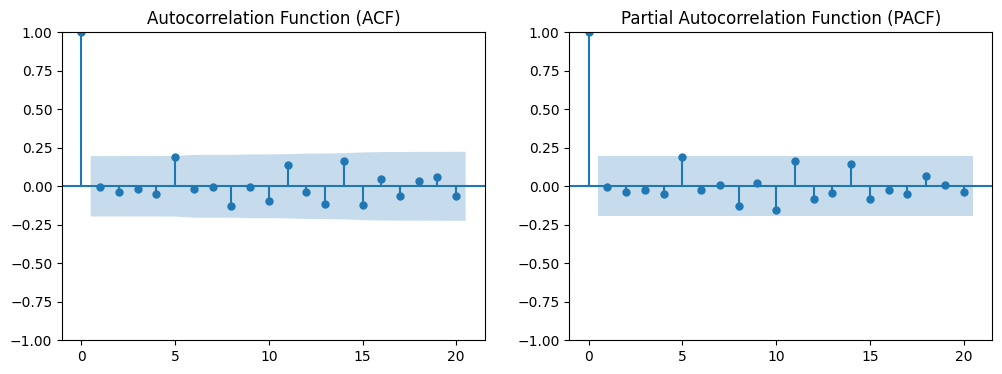

---- Model Diagnostics Results ----
Ljung-Box Test Statistic: 7.252524574621626
Ljung-Box p-value: 0.7014093573211158
Decision (Ljung-Box Test): Fail to Reject H0 (No Autocorrelation)

Augmented Dickey-Fuller Test Statistic: -1.3583317659818985
Augmented Dickey-Fuller p-value: 0.6020814791099101
Decision (ADF Test): Fail to Reject H0 (Non-Stationary)

Standard Error: 0.9076808284751978
95% Confidence Interval: (np.float64(-1.885834643930694), np.float64(1.6722742036920812))


In [5]:
# Flow 2: Model Diagnostics
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Generate Sample Data
# ---------------------------
np.random.seed(42)
n = 100
y = np.cumsum(np.random.randn(n))  # Simulated non-stationary time series data
df = pd.DataFrame({"y": y})

# ---------------------------
# 2. Fit ARIMA Model (Reference to Main ARIMA Model Flow)
# ---------------------------
arima_model = ARIMA(df["y"], order=(1, 1, 1))  # ARIMA(1,1,1)
arima_result = arima_model.fit()

# Extract residuals
residuals = arima_result.resid

# ---------------------------
# 3. Compute Autocorrelation Function (ACF & PACF)
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF Plot
plot_acf(residuals, ax=axes[0], lags=20)
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot
plot_pacf(residuals, ax=axes[1], lags=20)
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

# ---------------------------
# 4. Perform Ljung-Box Test (Check for White Noise)
# ---------------------------
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_statistic = ljung_box_result["lb_stat"].values[0]
lb_pvalue = ljung_box_result["lb_pvalue"].values[0]

# ---------------------------
# 5. Perform Augmented Dickey-Fuller Test (Check for Stationarity)
# ---------------------------
adf_result = adfuller(df["y"])
adf_statistic = adf_result[0]
adf_pvalue = adf_result[1]

# ---------------------------
# 6. Compute Standard Error and Confidence Interval
# ---------------------------
standard_error = np.std(residuals, ddof=1)
confidence_interval = (residuals.mean() - 1.96 * standard_error, residuals.mean() + 1.96 * standard_error)

# ---------------------------
# 7. Decision Rule
# ---------------------------
decision_lb = "Reject H0 (Autocorrelation Present)" if lb_pvalue < 0.05 else "Fail to Reject H0 (No Autocorrelation)"
decision_adf = "Reject H0 (Stationary)" if adf_pvalue < 0.05 else "Fail to Reject H0 (Non-Stationary)"

# ---------------------------
# 8. Print Results
# ---------------------------
print("---- Model Diagnostics Results ----")
print("Ljung-Box Test Statistic:", lb_statistic)
print("Ljung-Box p-value:", lb_pvalue)
print("Decision (Ljung-Box Test):", decision_lb)

print("\nAugmented Dickey-Fuller Test Statistic:", adf_statistic)
print("Augmented Dickey-Fuller p-value:", adf_pvalue)
print("Decision (ADF Test):", decision_adf)

print("\nStandard Error:", standard_error)
print("95% Confidence Interval:", confidence_interval)

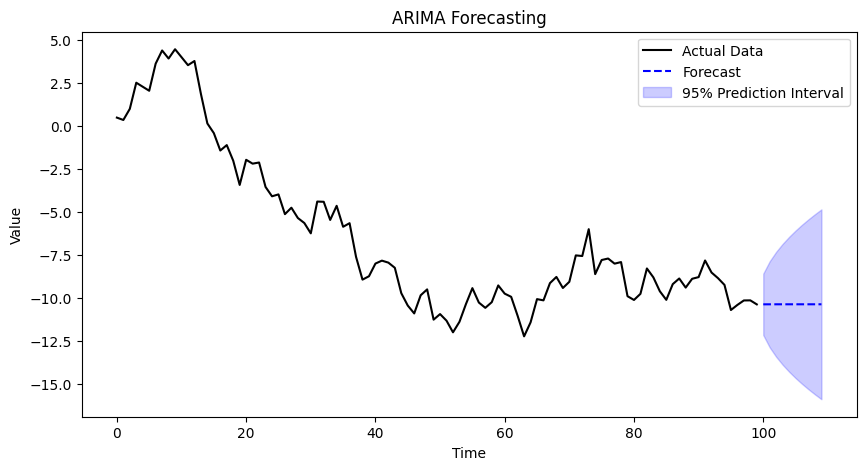

---- Forecasting Results ----
One-Step Ahead Forecast: -10.38116595680202

Multi-Step Ahead Forecast (Next 10 Points):
100   -10.381166
101   -10.379773
102   -10.379216
103   -10.378993
104   -10.378904
105   -10.378869
106   -10.378854
107   -10.378849
108   -10.378846
109   -10.378846
Name: predicted_mean, dtype: float64

Prediction Interval:
       lower y   upper y
100 -12.169902 -8.592430
101 -12.889183 -7.870363
102 -13.437710 -7.320722
103 -13.899731 -6.858255
104 -14.307059 -6.450749
105 -14.675688 -6.082049
106 -15.015004 -5.742704
107 -15.331092 -5.426606
108 -15.628167 -5.129526
109 -15.909303 -4.848388

Forecast Error Standard Deviation: nan
95% Confidence Interval for Forecast Errors: (np.float64(nan), np.float64(nan))
Decision: Forecast Errors Are High


In [ ]:
# Flow 3: Forecasting Future Values
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Generate Sample Data
# ---------------------------
np.random.seed(42)
n = 100
y = np.cumsum(np.random.randn(n))  # Simulated non-stationary time series data
df = pd.DataFrame({"y": y})

# ---------------------------
# 2. Fit ARIMA Model (Reference to Main ARIMA Model Flow)
# ---------------------------
arima_model = ARIMA(df["y"], order=(1, 1, 1))  # ARIMA(1,1,1)
arima_result = arima_model.fit()

# ---------------------------
# 3. Compute One-Step Ahead Forecasting
# ---------------------------
one_step_forecast = arima_result.forecast(steps=1).iloc[0]  # FIXED

# ---------------------------
# 4. Compute Multi-Step Ahead Forecasting
# ---------------------------
forecast_steps = 10  # Predict next 10 points
forecast_values = arima_result.forecast(steps=forecast_steps)

# ---------------------------
# 5. Compute Prediction Interval
# ---------------------------
forecast_ci = arima_result.get_forecast(steps=forecast_steps).conf_int()

# ---------------------------
# 6. Compute Forecast Errors & Confidence Interval
# ---------------------------
actual_values = df["y"].iloc[-forecast_steps:]  # Last known actual values
forecast_residuals = actual_values - forecast_values[:len(actual_values)]
forecast_error_std = np.std(forecast_residuals, ddof=1)
forecast_error_ci = (forecast_residuals.mean() - 1.96 * forecast_error_std, 
                     forecast_residuals.mean() + 1.96 * forecast_error_std)

# ---------------------------
# 7. Decision Rule
# ---------------------------
decision_forecast = "Model Forecasts Seem Reliable" if forecast_error_std < np.std(df["y"]) else "Forecast Errors Are High"

# ---------------------------
# 8. Plot Forecasting Results
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["y"], label="Actual Data", color="black")
plt.plot(np.arange(n, n + forecast_steps), forecast_values, label="Forecast", color="blue", linestyle="dashed")
plt.fill_between(np.arange(n, n + forecast_steps), forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                 color="blue", alpha=0.2, label="95% Prediction Interval")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("ARIMA Forecasting")
plt.legend()
plt.show()

# ---------------------------
# 9. Print Results
# ---------------------------
print("---- Forecasting Results ----")
print("One-Step Ahead Forecast:", one_step_forecast)
print("\nMulti-Step Ahead Forecast (Next 10 Points):")
print(forecast_values)
print("\nPrediction Interval:")
print(forecast_ci)

print("\nForecast Error Standard Deviation:", forecast_error_std)
print("95% Confidence Interval for Forecast Errors:", forecast_error_ci)
print("Decision:", decision_forecast)

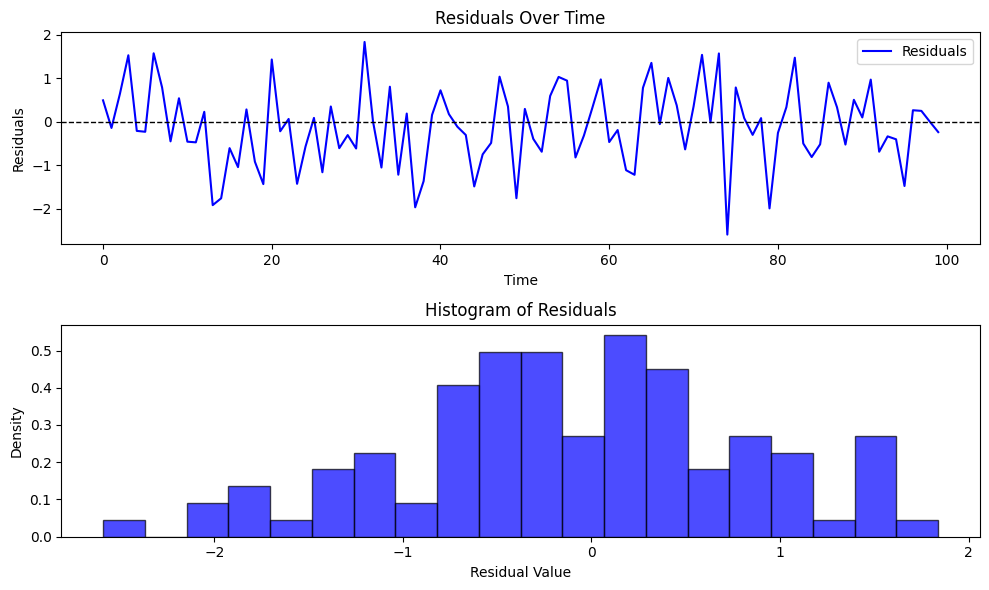

---- Residual Analysis Results ----
Durbin-Watson Statistic: 1.9807558257188493
Decision (Durbin-Watson): Fail to Reject H0 (No Autocorrelation)

Jarque-Bera Statistic: 0.6169530590259564
p-value: 0.7345651925996686
Skewness: -0.17224295072634427
Kurtosis: 2.8285409732135456
Decision (Jarque-Bera): Fail to Reject H0 (Residuals are Normal)


In [8]:
# Flow 4: Residual Analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson, jarque_bera

# ---------------------------
# 1. Generate Sample Data (Reference to Main ARIMA Model Flow)
# ---------------------------
np.random.seed(42)
n = 100
y = np.cumsum(np.random.randn(n))  # Simulated non-stationary time series data
df = pd.DataFrame({"y": y})

# ---------------------------
# 2. Fit ARIMA Model
# ---------------------------
arima_model = ARIMA(df["y"], order=(1, 1, 1))  # ARIMA(1,1,1)
arima_result = arima_model.fit()

# ---------------------------
# 3. Compute Residuals
# ---------------------------
residuals = arima_result.resid

# ---------------------------
# 4. Perform Durbin-Watson Test (Check for Autocorrelation in Residuals)
# ---------------------------
dw_statistic = durbin_watson(residuals)

# ---------------------------
# 5. Perform Jarque-Bera Test (Check for Normality of Residuals)
# ---------------------------
jb_statistic, jb_pvalue, skewness, kurtosis = jarque_bera(residuals)

# ---------------------------
# 6. Decision Rule
# ---------------------------
decision_dw = "Reject H0 (Autocorrelation Present)" if dw_statistic < 1.5 or dw_statistic > 2.5 else "Fail to Reject H0 (No Autocorrelation)"
decision_jb = "Reject H0 (Residuals are NOT Normal)" if jb_pvalue < 0.05 else "Fail to Reject H0 (Residuals are Normal)"

# ---------------------------
# 7. Plot Residuals & Normality Check
# ---------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Residual Time Series Plot
axs[0].plot(residuals, label="Residuals", color="blue")
axs[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axs[0].set_title("Residuals Over Time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Residuals")
axs[0].legend()

# Histogram of Residuals
axs[1].hist(residuals, bins=20, edgecolor="black", alpha=0.7, color="blue", density=True)
axs[1].set_title("Histogram of Residuals")
axs[1].set_xlabel("Residual Value")
axs[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# ---------------------------
# 8. Print Results
# ---------------------------
print("---- Residual Analysis Results ----")
print("Durbin-Watson Statistic:", dw_statistic)
print("Decision (Durbin-Watson):", decision_dw)
print("\nJarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_pvalue)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)
print("Decision (Jarque-Bera):", decision_jb)

In [9]:
# Flow 5: Stability Analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Generate Sample Data (Reference to Main ARIMA Model Flow)
# ---------------------------
np.random.seed(42)
n = 100
y = np.cumsum(np.random.randn(n))  # Simulated non-stationary time series data
df = pd.DataFrame({"y": y})

# ---------------------------
# 2. Fit ARIMA Model
# ---------------------------
arima_model = ARIMA(df["y"], order=(1, 1, 1))  # ARIMA(1,1,1)
arima_result = arima_model.fit()

# ---------------------------
# 3. Compute Characteristic Roots (Check Model Stability)
# ---------------------------
ar_roots = np.abs(arima_result.arroots) if len(arima_result.arroots) > 0 else np.array([])
ma_roots = np.abs(arima_result.maroots) if len(arima_result.maroots) > 0 else np.array([])

# Stability condition: All roots must lie inside the unit circle (< 1)
ar_stability = np.all(ar_roots < 1)
ma_stability = np.all(ma_roots < 1)

# ---------------------------
# 4. Compute Mean Reversion Time (Time Taken to Return to Mean)
# ---------------------------
# Mean reversion time = -1 / log(|AR Coefficient|)
if len(arima_result.arparams) > 0:
    ar_coeff = arima_result.arparams[0]  # First AR coefficient
    if np.abs(ar_coeff) < 1:  # Check stationarity condition
        mean_reversion_time = -1 / np.log(np.abs(ar_coeff))
    else:
        mean_reversion_time = np.nan  # Not stationary
else:
    mean_reversion_time = np.nan  # No AR term in model

# ---------------------------
# 5. Decision Rule
# ---------------------------
decision_roots = "Model is Stable" if ar_stability and ma_stability else "Model is Unstable"
decision_reversion = "Valid Mean Reversion Time" if not np.isnan(mean_reversion_time) else "Mean Reversion Not Defined"

# ---------------------------
# 6. Print Results
# ---------------------------
print("---- Stability Analysis Results ----")
print("AR Characteristic Roots:", ar_roots)
print("MA Characteristic Roots:", ma_roots)
print("Decision (Characteristic Roots):", decision_roots)
print("\nMean Reversion Time:", mean_reversion_time)
print("Decision (Mean Reversion Time):", decision_reversion)

---- Stability Analysis Results ----
AR Characteristic Roots: [2.50183581]
MA Characteristic Roots: [2.40513131]
Decision (Characteristic Roots): Model is Unstable

Mean Reversion Time: 1.090483065061192
Decision (Mean Reversion Time): Valid Mean Reversion Time


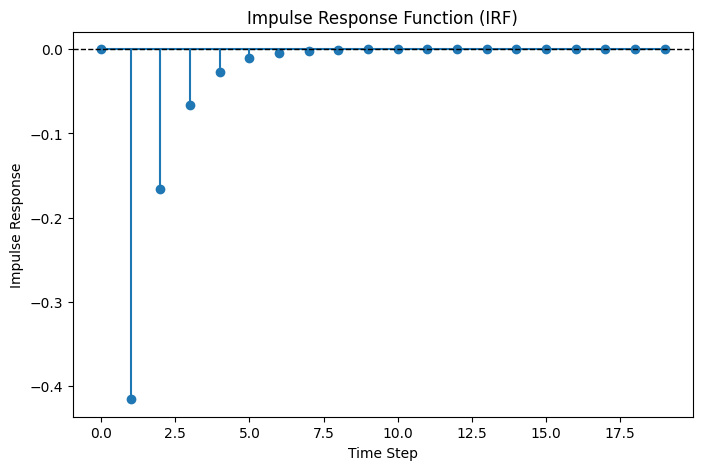

---- Impulse Response Function Results ----
Impulse Response Values: [ 0.00000000e+00 -4.15777715e-01 -1.66189049e-01 -6.64268410e-02
 -2.65512392e-02 -1.06127025e-02 -4.24196602e-03 -1.69554133e-03
 -6.77718867e-04 -2.70888627e-04 -1.08275941e-04 -4.32785959e-05
 -1.72987355e-05 -6.91441677e-06 -2.76373723e-06 -1.10468370e-06
 -4.41549238e-07 -1.76490094e-07 -7.05442354e-08 -2.81969884e-08]
Decision (Impulse Response Decay): Shock response decays → Model is Stable


In [10]:
# Flow 6: Impulse Response Function
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Generate Sample Data (Reference to Main ARIMA Model Flow)
# ---------------------------
np.random.seed(42)
n = 100
y = np.cumsum(np.random.randn(n))  # Simulated non-stationary time series data
df = pd.DataFrame({"y": y})

# ---------------------------
# 2. Fit ARIMA Model
# ---------------------------
arima_model = ARIMA(df["y"], order=(1, 1, 1))  # ARIMA(1,1,1)
arima_result = arima_model.fit()

# ---------------------------
# 3. Compute Impulse Response Function (IRF)
# ---------------------------
irf_steps = 20  # Number of time steps to simulate response
irf_values = np.zeros(irf_steps)

# Apply a unit impulse at t=0 and observe its effect
shock = np.zeros(irf_steps)
shock[0] = 1  # One-time shock at t=0

# Propagate the shock through ARIMA dynamics
for t in range(1, irf_steps):
    irf_values[t] = arima_result.arparams[0] * irf_values[t - 1] if len(arima_result.arparams) > 0 else 0
    irf_values[t] += arima_result.maparams[0] * shock[t - 1] if len(arima_result.maparams) > 0 else 0

# ---------------------------
# 4. Plot Impulse Response Function
# ---------------------------
plt.figure(figsize=(8, 5))
plt.stem(range(irf_steps), irf_values, basefmt="C0-", linefmt="C0-", markerfmt="C0o")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Impulse Response")
plt.title("Impulse Response Function (IRF)")
plt.show()

# ---------------------------
# 5. Decision Rule
# ---------------------------
# If IRF values gradually decay towards zero, the system is stable.
decision_irf = "Shock response decays → Model is Stable" if np.abs(irf_values[-1]) < 0.1 else "Shock response persists → Model May Be Unstable"

# ---------------------------
# 6. Print Results
# ---------------------------
print("---- Impulse Response Function Results ----")
print("Impulse Response Values:", irf_values)
print("Decision (Impulse Response Decay):", decision_irf)

In [11]:
# Flow 7: Information Criteria
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Generate Sample Data (Reference to Main ARIMA Model Flow)
# ---------------------------
np.random.seed(42)
n = 100
y = np.cumsum(np.random.randn(n))  # Simulated non-stationary time series data
df = pd.DataFrame({"y": y})

# ---------------------------
# 2. Fit ARIMA Model
# ---------------------------
arima_model = ARIMA(df["y"], order=(1, 1, 1))  # ARIMA(1,1,1)
arima_result = arima_model.fit()

# ---------------------------
# 3. Compute Information Criteria
# ---------------------------
aic = arima_result.aic  # Akaike Information Criterion
bic = arima_result.bic  # Bayesian Information Criterion

# ---------------------------
# 4. Decision Rule
# ---------------------------
decision_ic = (
    "Lower AIC/BIC values indicate a better model fit."
    "\nCompare multiple models and choose the one with the lowest AIC/BIC."
)

# ---------------------------
# 5. Print Results
# ---------------------------
print("---- Information Criteria Results ----")
print(f"Akaike Information Criterion (AIC): {aic:.4f}")
print(f"Bayesian Information Criterion (BIC): {bic:.4f}")
print("Decision:", decision_ic)

---- Information Criteria Results ----
Akaike Information Criterion (AIC): 268.8499
Bayesian Information Criterion (BIC): 276.6353
Decision: Lower AIC/BIC values indicate a better model fit.
Compare multiple models and choose the one with the lowest AIC/BIC.
